
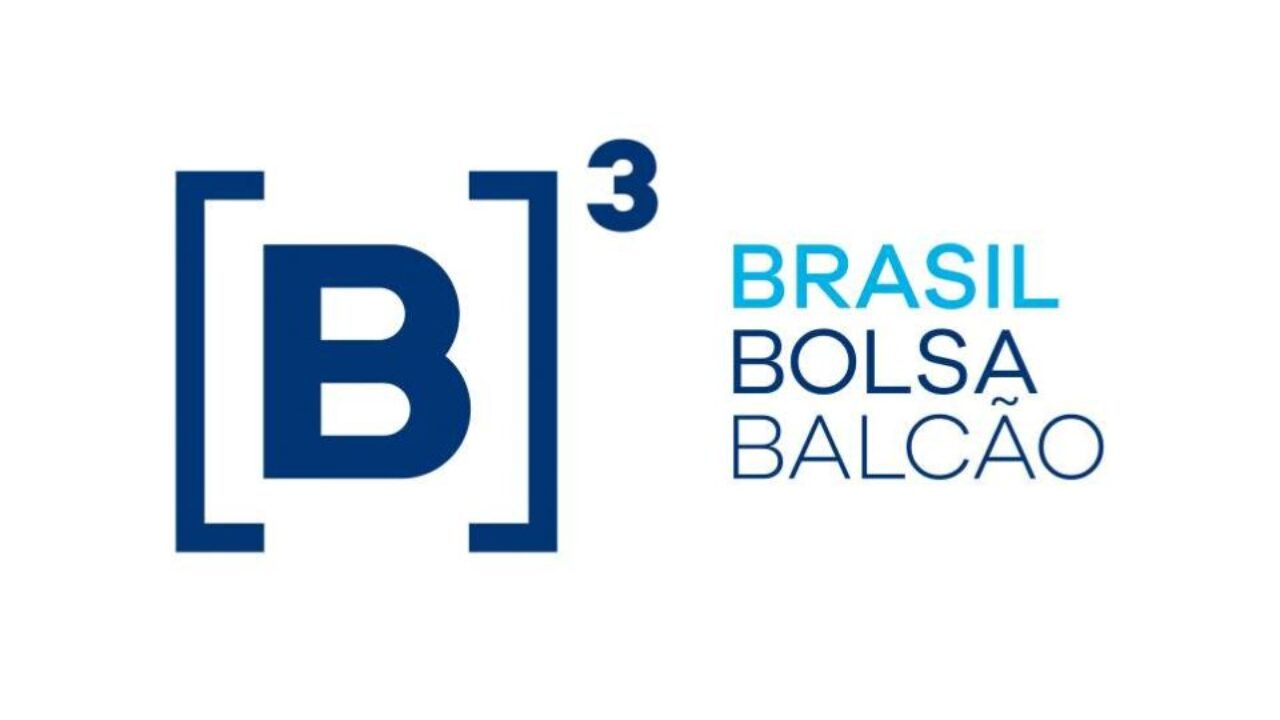

---


**<center>Comparativo de desempenho de varios setores durante cada mandato presidencial</center>**

<center>Afonso Neris | Janeiro de 2023</center>


---


## 1 - Resumo

<p>       O objetivo geral do artigo é demonstrar o desempenho de indices da B3 durante o mandato de cada presidente à partir de  2003. Usamos web scraping para coletar os dados direto do site da B3 e algumas metricas para avaliar o desempenho de cada indice.</p>

<p>      Levamos em considerações alguns eventos externos que tiveram forte influencia em quedas na economia global, como a crise nos EUA, conhecida como subprime e o período de pandemia mundial causado pelo Covid 19. </p>


## 2 - Definição de Bibliotecas

O pacote Kora é um pacote associado ao Selenium que permite utilizar a ferramenta de webdrive na maquina virtual do Colab.

Utilizamos o Kaleido para gerar um grafico estático no formato JPEG à partir do grafico gerado pelo plotly.

Já o selenium é uma biblioteca que permite interações automatizadas com páginas web, permitindo o acesso, consuta e download de arquivos diretamente no site da B3.

In [ ]:
#Instalação de bibliotecas de terceiro

!pip install -q kora
!pip install -U kaleido
!pip install -q selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 5.0 MB/s eta 0:00:00


In [ ]:
#Bibliotecas Nativas
from time import sleep
from datetime import date,datetime

#Bibliotecas de Terceiros
import pandas as pd
from selenium.webdriver.common.by import By
import plotly.express as px
from kora.selenium import wd
import plotly.graph_objects as go


# 3 - Alguns pontos importantes

## 3.1 O que é indice B3 ?

Indice é uma carteira teórica que representa uma parcela de ações de um determinado setor. Esses indices funcionam como um termômetro para os investidores, representados por pontos eles demonstram o desempenho das ações das empresas que compõe os indices.Empresas com maior liquidez compões os indices. Uma ação de empresa pode compor mais de um indice, que são agrupados por setores ou algum outra caracteristica comum, como o indice de small caps por exemplo.



## 3.2 Como é calculado os pontos do indice?



Os pontos dos indices são calculados com base no peso da ação no indice a cotação atual. Logo o valor em pontos de um indice é a cotação das ações do indice multiplicado pelo seu respectivo peso.


# 4 - Funções

### 4.1 Buscando Cotações

Existem bibliotecas que coletam a cotação dos indices. Como o artigo tem como objetivo de compor um portifólio, decidi usar a biblioteca selenium e capturar esses dados de outra foma. Com o uso da biblioteca é feito o download dos arquivos CSV disponibilizados pela propria B3, ao final é renomeado o arquivo adicionando o nome do indice e o intervalo de tempo.

In [ ]:
def buscar_cotacao(start_date,indice,end_date,flag=0):
    while flag != 1:
        
      if end_date > date.today().year : 
          end_date = date.today().year
          flag = 1

#Acessando site da B3          
      url = f'https://sistemaswebb3-listados.b3.com.br/indexStatisticsPage/monthly-evolution/{indice.upper()}?language=pt-br'
      wd.get(url)
      sleep(3)

#Selecionando Filtros
      wd.find_element(By.ID,'selectFrom').send_keys(start_date)
      wd.find_element(By.ID,'selectTo').send_keys(end_date)
      sleep(3)

#Baixando Arquivo CSV
      wd.find_element(By.XPATH,'//*[@id="divContainerIframeB3"]/div/div[1]/form/div[1]/div[3]/button').click()
      sleep(3)

      wd.find_element(By.XPATH,'//*[@id="divContainerIframeB3"]/div/div[1]/form/div[2]/div[3]/div/div[1]/div[2]/p/a').click()                           
      sleep(3)

#Renomeando Arquivo Baixado
      arquivos = !ls -1t *.csv
      arquivo = arquivos[0]
      file_name = arquivo.split(sep='.')
      novo_arquivo = str(indice) + '-' + file_name[0] + '-' + str(start_date) + '-' + str(end_date) + '.' + file_name[1] 
      !mv  ./{arquivo} ./{novo_arquivo}

#Ajustando Variaveis
      start_date +=10
      end_date +=10

### 4.2 Normalizando Valores

Existe uma diferença grande entre os pontos dos indices. Alguns indices tem muitos pontos por ter varios ativos que compões ou ativos com cotação de valor alto. Já outros indices contem poucos ativos e/ou ativos de baixo valor.

In [ ]:
def normalizar(df):

#Normalizando a coluna Valor, ajustando entre os valores 0 e 1
  df_min_max_scaled = df.copy()  
  df_min_max_scaled['Valor'] = (df_min_max_scaled['Valor'] - df_min_max_scaled['Valor'].min()) / (df_min_max_scaled['Valor'].max() - df_min_max_scaled['Valor'].min())     
  return df_min_max_scaled

### 4.3 Filtrando DataFrame

Após o download do arquivo feito, precisamos filtrar o dataframe e fazer alguns ajustes para que possamos gerar um grafico com qualidade.Foi definido alguns limites de data para ajustar ao grafico, criado novas series para melhorar a qualidade dos dados e substituidos alguns caracteres.

In [ ]:
def filtro_df(indice):

  df = pd.DataFrame()
  indice_df = pd.DataFrame()

#Transformando arquivos CSV em DataFrame
  df = pd.read_csv(f'{indice}-Evolucao_Mensal-2000-2010.csv',on_bad_lines='skip',header=1,sep=';',encoding='latin-1')
  df['mes-ano'] = df['Ano'].map(str) + df['Mês'].map(str)
  df['mes-ano'] = pd.to_datetime(df['mes-ano'], format='%Y%m')
  indice_df = indice_df.append(df)

#Transformando arquivos CSV em DataFrame
  df = pd.read_csv(f'{indice}-Evolucao_Mensal-2010-2020.csv',on_bad_lines='skip',header=1,sep=';',encoding='latin-1')
  df['mes-ano'] = df['Ano'].map(str) + df['Mês'].map(str)
  df['mes-ano'] = pd.to_datetime(df['mes-ano'], format='%Y%m')
  indice_df = indice_df.append(df)

#Transformando arquivos CSV em DataFrame
  df = pd.read_csv(f'{indice}-Evolucao_Mensal-2020-2023.csv',on_bad_lines='skip',header=1,sep=';',encoding='latin-1')
  df['mes-ano'] = df['Ano'].map(str) + df['Mês'].map(str)
  df['mes-ano'] = pd.to_datetime(df['mes-ano'], format='%Y%m')
  indice_df = indice_df.append(df)

#Ordenando DataFrame  
  indice_df.sort_values(['mes-ano'],inplace=True)

#Ajustando Formatação da coluna Valor
  lista = [ ]
  for i in range(0,len(indice_df['Valor']),1):
    x = indice_df.iloc[i][2]
    x = x.replace('.','')
    x = x.strip(',')
    x = x[:-3]
    lista.append(int(x))

  indice_df['Valor'] = lista  
  indice_df = normalizar(indice_df)
  indice_df['indice'] = indice

#Filtrando DataFrame 
  indice_df = indice_df.query('Ano > 2002')
  
  return indice_df

# 5 - Indices

É necessario usar as funções para cada indice escolhido. Ao final todos os dataframe são concatenados formando apenas um dataframe composto por todos os indices. Logo após é gerado o grafico.

### 5.1 IMOB

- O objetivo do IMOB é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade dos setores da atividade imobiliária compreendidos por exploração de imóveis e construção civil.

In [ ]:
start_date = 2000
indice = 'imob'
end_date = start_date + 10
flag = 0
buscar_cotacao(start_date,indice,end_date)
imob = filtro_df(indice)


###5.2  IFNC

- O objetivo do IFNC é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade dos setores de intermediários financeiros, serviços financeiros diversos, previdência e seguros.

In [ ]:
start_date = 2000
indice = 'ifnc'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
ifnc = filtro_df(indice)



### 5.3 IEEX

- O objetivo do IEE é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade do setor de energia elétrica.

In [ ]:
start_date = 2000
indice = 'ieex'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
ieex = filtro_df(indice)

### 5.4 UTIL

- O objetivo do UTIL é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade do setor de utilidade pública (energia elétrica, água e saneamento e gás).

In [ ]:
start_date = 2000
indice = 'util'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
util = filtro_df(indice)

###5.5 INDX

- O objetivo do INDX é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade dos setores da atividade industrial compreendidos por materiais básicos, bens industriais, consumo cíclico, consumo não cíclico, tecnologia da informação e saúde.

In [ ]:
start_date = 2000
indice = 'indx'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
indx = filtro_df(indice)

###5.6 ICON

- O objetivo do ICON é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade dos setores de consumo cíclico, consumo não cíclico e saúde.

In [ ]:
start_date = 2000
indice = 'icon'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
icon = filtro_df(indice)

###5.7 IMAT

- O objetivo do IMAT é ser o indicador do desempenho médio das cotações dos ativos de maior negociabilidade e representatividade do setor de materiais básicos.

In [ ]:
start_date = 2000
indice = 'imat'
end_date = start_date + 10
flag = 0
df = buscar_cotacao(start_date,indice,end_date)
imat = filtro_df(indice)

#6 - Graficos

As representações graficas escolhidas são para mostrar o desempenho dos indices frente a cada presidente e tambem frente a alguns fatores que consideramos relevantes, como crises de saude, crises financeiras, conflitos e outros fatores. Todos os graficos são interativos, podendo ser selecionado quais indices devem aparecer apenas clicando no nome do indice na legenda ao lado direito.

In [ ]:
df = pd.DataFrame()
df = df.append([imob,ifnc,ieex,util,indx,icon,imat])

###6.1 Indices em cada mandato

In [ ]:
fig = px.line(df,
              x="mes-ano",
              y="Valor",
              color='indice', 
              line_dash='indice',
              color_discrete_sequence=px.colors.qualitative.Dark24
              )

fig.add_vrect(x0='2003-01',x1='2011-01',fillcolor='#4F4F4F',opacity=0.3,line_width=0)
fig.add_trace(go.Scatter(x=['2007-01'],y=[1.1],mode='text',text='<b>Lula',textposition='top center',showlegend=False))

fig.add_vrect(x0='2011-01',x1='2016-09',fillcolor='#808080',opacity=0.25,line_width=0)
fig.add_trace(go.Scatter(x=['2014-02'],y=[1.1],mode='text',text='<b>Dilma',textposition='top center',showlegend=False))

fig.add_vrect(x0='2016-09',x1='2019-01',fillcolor='#C0C0C0',opacity=0.25,line_width=0)
fig.add_trace(go.Scatter(x=['2017-10'],y=[1.1],mode='text',text='<b>Temer',textposition='top center',showlegend=False))

fig.add_vrect(x0='2019',x1='2023',fillcolor='#DCDCDC',opacity=0.25,line_width=0)
fig.add_trace(go.Scatter(x=['2021'],y=[1.1],mode='text',text='<b>Bolsonaro',textposition='top center',showlegend=False))

fig.show()

###6.2 Indices em cada crise financeira

Apresentamos tambem as variações frente as crises financeiras internas e externas. Levamos em consideração a crise nos EUA, recessão no Brasil e a crise causada pela pandemia do Covid-19.

In [ ]:
fig = px.line(df,
              x="mes-ano",
              y="Valor",
              color='indice', 
              line_dash='indice',
              color_discrete_sequence=px.colors.qualitative.Dark24
              )

fig.add_vrect(x0='2007-01',x1='2008-12',fillcolor='#A9A9A9',opacity=0.25,line_width=0)
fig.add_trace(go.Scatter(x=['2008-01'],y=[1.1],mode='text',text='<b>Crise dos subprimes',textposition='top center',showlegend=False))

fig.add_vrect(x0='2014-01',x1='2016-12',fillcolor='#808080',opacity=0.3,line_width=0)
fig.add_trace(go.Scatter(x=['2015-07'],y=[1.1],mode='text',text='<b>Grande recessão brasileira',textposition='top center',showlegend=False))

fig.add_vrect(x0='2020-03',x1='2023-01',fillcolor='#696969',opacity=0.25,line_width=0)
fig.add_trace(go.Scatter(x=['2021-09'],y=[1.1],mode='text',text='<b>Covid-19',textposition='top center',showlegend=False))

fig.show()

##7 -  Conclusões

<p>     Apresentamos três modelos de representação grafica indicando o desempenho dos indices escolhidos. No primeiro modelo os indices imat e ifnc tiveram um desempenho relevante durante o governo Lula e o governo Bolsonaro, mesmo enfrentando crises durante esse período. Após a recuperação da Crise do Subprime, o indice imob que representa os ativos do setor imobiliario teve uma forte queda durante o governo Dilma.<br>

<p>     A crise do subprime teve forte influencia na economia brasileira. Podemos observar que alguns indices tiveram quedas acima de 80% durante esse período. Outro fator importante na economia brasileira mais de 10 anos após o subprime foi a pandemia por covid-19 na qual varios setores precisaram ser fechado durante o lockdown e empresas e governo tiveram custos inesperados durante todo o período.<br>

<p>     
